<a href="https://colab.research.google.com/github/ylorenzi/Projeto_Modulo_3/blob/main/Projeto_Modulo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lockdown funciona!

## O caso de Araraquara


![](https://static.6minutos.uol.com.br/2021/03/shutterstock_1845160789-1200x675.jpg)

# Introdução

O termo em inglês lockdown, que em tradução literal significa fechamento total, se popularizou quando a medida foi adotada pela Itália no auge da primeira onda da COVID-19 em março do ano passado, quando morriam cerca de 1 mil pessoas por dia no país europeu.

Muitos municípios utilizaram equivocadamente esse termo ao adotar medidas de restrição que estavam distantes do conceito original. O presidente da Sociedade Mineira de Infectologia, Estevão Urbano, afirma que o município de Araraquara foi o que mais se aproximou da medida de forma correta.

Araraquara foi o primeiro município paulista com mais de 100 mil habitantes a proibir a circulação de veículos e pessoas ao longo do dia, a não ser em casos excepcionais. O transporte coletivo foi suspenso e outros serviços essenciais, drasticamente restringidos.

A medida foi dura, mas teve excelentes resultados. Dois meses após confinamento, Araraquara teve uma queda 74% na média móvel de casos de COVID-19.

# Objetivo

Esse projeto tem como objetivo medir qual foi o impacto do lockdown realizado em Araraquara. Para isso, precisaríamos ter o contrafactual, ou seja, saber quantos casos teriam ocorrido caso o lockdown não tivesse acontecido. 

Para prever quantos casos teriam ocorrido nessa situação hipotético utilizaremos o Prophet, ferramenta de forecasting Open Source desenvolvida pelo Facebook.

Importanto as livrarias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fbprophet import Prophet

# Dados

Embora por conta da Lei de Acesso à Informação os dados sobre a COVID-19 devem ser públicos, o município de Araraquara não disponibiliza as informações em uma base de dados estruturada, e sim em boletins diários que são publicados em seu site.

Para coletar esses dados seria necessário acessar cada um desses boletins.  

Felizmente os dados foram gentilmente disponibilizado pela coordenadoria do projeto [Urbie Maps](https://storymaps.arcgis.com/stories/a2fc129ca9044a0e9785dc85f2534e1a).



Importação e formatação dos dados:

In [2]:
url_dados = "https://github.com/ylorenzi/Projeto_Modulo_3/raw/main/dados/Araraquara.csv"

In [3]:
dados = pd.read_csv(url_dados,sep=";")

In [4]:
dados["Data de Confirmação"] = pd.to_datetime(dados["Data de Confirmação"],format= "%d/%m/%Y")

Criação de média móveis de 7 dias para novas notificações de casos de COVID e óbitos:

In [5]:
dados["media_movel_casos"] = dados["Novas notificações"].rolling(window=7,center=False).mean()
dados["media_movel_obitos"] = dados["Novos óbitos"].rolling(window=7,center=False).mean()

In [6]:
dados.tail(3)

,Data de Confirmação,Casos Confirmados,Novas notificações,Recuperados,Em quarentena,Óbitos,Enfermaria,UTI,Suspeitos,Novos óbitos,media_movel_casos,media_movel_obitos
378,2021-06-28,25430,26,23901,1023,506,96,93,338,1,123.000000,1.857143
379,2021-06-29,25591,161,24077,1005,509,100,81,604,3,129.571429,2.142857
380,2021-06-30,25705,114,24164,1028,513,100,81,391,4,123.000000,2.142857


Função que executa o Prophet e retorna uma previsão e um gráfico.

Parâmetros são a coluna escolhida para serem feitas as previsões e quantos dias a serem previsto.

In [69]:
def profeta(coluna,dias):
    total = len(dados)
    df = pd.DataFrame()
    df["ds"] = dados["Data de Confirmação"][:(total-dias)]
    df["y"] = dados[coluna][:(total-dias)]
    modelo = Prophet(seasonality_mode="multiplicative")
    modelo.add_country_holidays(country_name="BR")
    modelo.fit(df)
    dataframefuturo = modelo.make_future_dataframe(periods=dias)
    previsao = modelo.predict(dataframefuturo)
    modelo.plot(previsao,xlabel="Data",ylabel=coluna,figsize=(20,10));
    df_teste = pd.DataFrame()
    df_teste["ds"]= dados["Data de Confirmação"][(total-dias):]
    df_teste["y"]= dados[coluna][(total-dias):]
    plt.plot(df_teste["ds"],df_teste["y"],".r",label="casos não utilizados")
    plt.plot(dados["Data de Confirmação"],dados["media_movel_casos"],"r",label="média móvel casos")
    #plt.plot(dados["Data de Confirmação"],dados["media_movel_obitos"],"r")
    plt.legend()
    return previsao

### Com a função acima podemos fazer uma previsão de quantos casos de COVID teriam ocorrido sem o lockdown. Para isso fornecemos ao Prophet informações sobre casos até o dia em que começou o lockdown.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


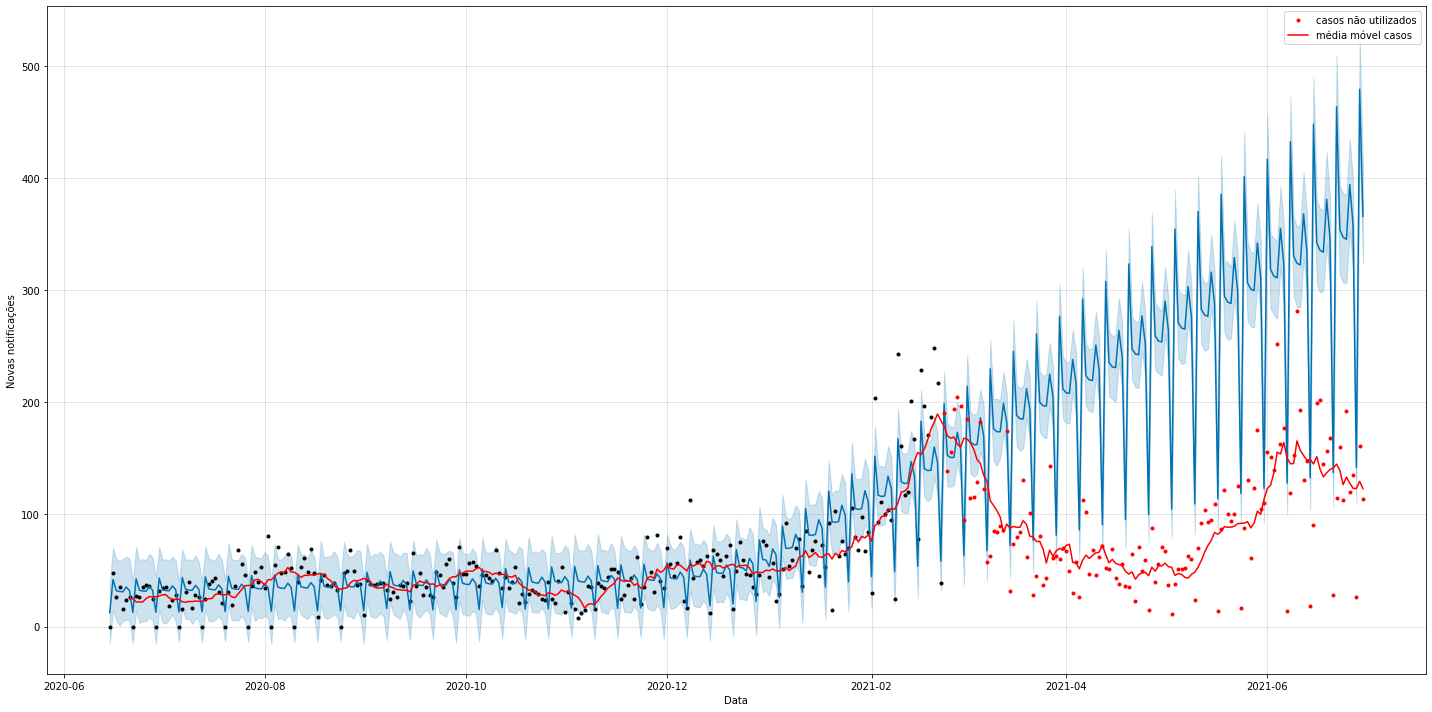

In [70]:
previsao = profeta("Novas notificações",128)

A linha azul representa a previsão feita para o Prophet.

A previsão foi feita utilizando os pontos pretos (casos de covid). 

Os pontos vermelhos são os casos de covid após o lockdown e que não foram fornecidos ao modelo.

### Dessa forma a previsão é baseada partindo da hipótese que a tendência de casos se manteria.

# Comparando a realidade com a previsão

O último passo do projeto é comparar a quantidade de casos de COVID prevista com a quantidade de casos que ocorreram de fato.

## Soma dos casos previstos

In [78]:
casos_previstos = previsao[["ds","yhat"]].query("ds > '2021-02-22'").sum().values
casos_previstos

array([31904.03852134])

## Soma dos casos reais

In [79]:
casos_reais = df_teste.sum().values
casos_reais

array([12212])

## Para chegar na quantidade de casos evitados pelo lockdown basta comparar as duas somas.

In [82]:
casos_evitados = casos_previstos - casos_reais
int(casos_evitados)

19692

# Conclusões

Esse projeto teve como objetivo medir qual o impacto de um lockdown na redução no número de casos. Para tal, foi escolhido o município de Araraquara, que foi o município que mais se aproximou de um verdadeiro lockdown.

Para prever quantos casos teriam ocorrido caso o lockdown não tivesse acontecido utilizamos o Prophet e fornecemos a ele dados de casos de COVID até o dia em que se iniciou lockdown.

A previsão foi de que 31.904 casos teriam ocorrido, em contraste aos 12.212 casos reportados. Com isso concluímos que 19.692 casos foram evitados por conta do lockdown.

Vale lembrar que essa previsão é baseada na hipótese a tendência de evolução dos casos seria a mesma sem o fechamento. Essa é uma hipótese bem forte, dado que possivelmente o comportamento dos habitantes de Araraquara mudaria com a alta presença do vírus.

